In [3]:
import glob
import os
import pandas as pd

from ase.io import read, write
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from tensorpotential.calculator import TPCalculator

# 1 --- CONFIG ---
poscar_path = "./bcc/*"   
elements=" Al Fe\n"
fmax = 0.02
csv_out = "results.csv"

In [5]:
# 2 --- MODELS --- 

# Option A : charger un modèle sauvegardé 
#saved_model_dir = "/chemin/vers/fit/seed/1/saved_model/"  # remplacer
model_path = "/Users/jcc/.cache/grace/GRACE-1L-OMAT"

# Option B : charger un "foundation model" fourni par ICAMS 
# ['GRACE-1L-MP-r6', 'GRACE-2L-MP-r5', 'GRACE-2L-MP-r6', 'GRACE-FS-OAM', 'GRACE-1L-OAM', 'GRACE-2L-OAM', 'GRACE-FS-OMAT', 'GRACE-1L-OMAT', 'GRACE-2L-OMAT'] 
#model_path = grace_fm('GRACE-1L-OMAT')  


In [7]:
# 3 --- Calculator ---
calc = TPCalculator(model_path)

results = []

for poscar_file in glob.glob(poscar_path):
    print(f"==> Traitement {poscar_file}")
    try:
        # elements
        with open(poscar_file, 'r') as file:
            lignes = file.readlines()
        lignes[5] = elements
        with open(poscar_file, 'w') as file:
            file.writelines(lignes)
        
        # lire ASE
        atoms = read(poscar_file, format="vasp")
        atoms.set_calculator(calc)

        # énergie initiale
        E_init = atoms.get_potential_energy()
        print(f"==> E_init (eV) {E_init}")

        # relaxer (cellule + positions)
        atoms_ucf = UnitCellFilter(atoms)
        dyn = BFGS(atoms_ucf, logfile="relax.log")  
        dyn.run(fmax=fmax)

        # énergie finale
        E_final = atoms.get_potential_energy()
        print(f"==> E_init (eV) {E_final}")

        # sauvegarder maille relaxée à côté
        #out_file = os.path.join(os.path.dirname(os.path.dirname(poscar_file), "POSCAR_relax")
        #out_file = os.path.splitext(poscar_file)[0] + "_relax.vasp"
        out_file = poscar_file + "_relax.vasp"
        write(out_file, atoms, format="vasp")

        # stocker résultats
        results.append({
            "file": os.path.splitext(poscar_file)[1],
            "E_init (eV)": E_init,
            "E_final (eV)": E_final,
            "deltaE (eV)": E_final - E_init
        })

    except Exception as e:
        print(f"Erreur sur {poscar_file}: {e}")

# --- écrire CSV ---
df = pd.DataFrame(results)
df.to_csv(csv_out, index=False)
print(f"Résultats écrits dans {csv_out}")

==> Traitement ./bcc/POSCAR.75


/var/folders/7p/twdtgkrd38n80nhyhlk6k7500000gn/T/ipykernel_94280/3753855486.py:18: DeprecationWarning: Please use atoms.calc = calc
  atoms.set_calculator(calc)
I0000 00:00:1763111845.597915  942325 service.cc:145] XLA service 0x6000015e4400 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763111845.598325  942325 service.cc:153]   StreamExecutor device (0): Host, Default Version
2025-11-14 10:17:25.708304: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763111846.823458  942325 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/var/folders/7p/twdtgkrd38n80nhyhlk6k7500000gn/T/ipykernel_94280/3753855486.py:25: FutureWarning: Import UnitCellFilter from ase.filters
  atoms_ucf = UnitCellFilter(atoms)


==> E_init (eV) -77.36127650843318
==> E_init (eV) -116.54546487452328
==> Traitement ./bcc/POSCAR.50
==> E_init (eV) -66.07133921776436
==> E_init (eV) -99.17388162338965
==> Traitement ./bcc/POSCAR.94
==> E_init (eV) -126.46676278123874
==> E_init (eV) -128.5366577714548
==> Traitement ./bcc/POSCAR.25
==> E_init (eV) -54.95465650436397
==> E_init (eV) -80.69090701976396
==> Traitement ./bcc/POSCAR.6
==> E_init (eV) -61.27832712204005
==> E_init (eV) -63.15764882883337
==> Traitement ./bcc/bcc_Al-Fe
Erreur sur ./bcc/bcc_Al-Fe: [Errno 21] Is a directory: './bcc/bcc_Al-Fe'
==> Traitement ./bcc/SQS-binary
Erreur sur ./bcc/SQS-binary: [Errno 21] Is a directory: './bcc/SQS-binary'
Résultats écrits dans results.csv


RMSE between DFT and GNN : 0.04893648618043084 eV/at


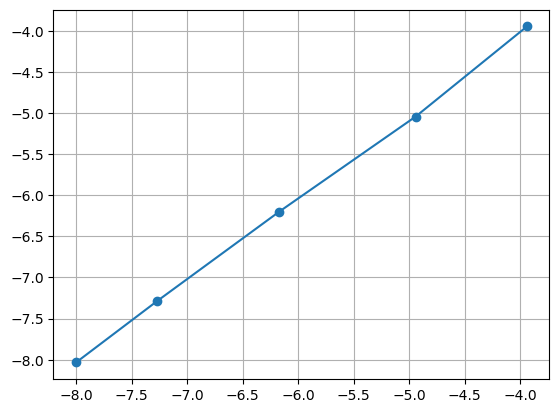

In [9]:
# 4 --- Comparison ---
import matplotlib.pyplot as plt
import numpy as np

x = [6, 25, 50, 75, 94]
dft = [-63.0535, -79.0929, -98.7332, -116.3053, -128.0375]
gnn = [-63.1576, -80.6909, -99.1738, -116.5454, -128.5366]   
dft = np.array([val / 16 for val in dft])
gnn = np.array([val / 16 for val in gnn])

# Calcul RMSE
rmse = np.sqrt(np.mean((dft - gnn)**2))
print("RMSE between DFT and GNN :", rmse, "eV/at")

# Tracé y = f(x) avec dft en x et gnn en y
plt.plot(dft, gnn, marker='o')
plt.grid(True)
plt.show()

In [11]:
#kj/mol
rmse*96.486

4.72168580560505